In [26]:
import sys
sys.path.append('..')
from cmost_exposure import Exposure, scan_headers, load_by_filepath

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import vstack

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

cmost_dir = '../data'

In [12]:
files1 = scan_headers(cmost_dir+'/20210813')
files2 = scan_headers(cmost_dir+'/20210814')
files3 = scan_headers(cmost_dir+'/20210815')
all_files = vstack([files1, files2, files3])
all_files.sort('DATE')

all_files.pprint_all()

files30min = all_files[all_files['EXPTIME'] == 1800]
files2hr = all_files[all_files['EXPTIME'] == 6400]

                   FILEPATH                   READOUTM            DATE            EXPTIME LED  TEMP CAMERAID   DETID   GAIN
--------------------------------------------- -------- -------------------------- ------- --- ----- -------- --------- ----
../data/20210813/cmost111_20210813230156.fits  DEFAULT 2021-08-14 00:01:56.949686  1800.0 0.0 140.0    cmost BSI-1-7-3 high
../data/20210814/cmost111_20210814000156.fits  DEFAULT 2021-08-14 03:35:17.436678  6400.0 0.0 140.0    cmost BSI-1-7-3 high
../data/20210814/cmost111_20210814040517.fits  DEFAULT 2021-08-14 05:05:18.024920  1800.0 0.0 145.0    cmost BSI-1-7-3 high
../data/20210814/cmost111_20210814050518.fits  DEFAULT 2021-08-14 08:38:38.512830  6400.0 0.0 145.0    cmost BSI-1-7-3 high
../data/20210814/cmost111_20210814090838.fits  DEFAULT 2021-08-14 10:08:39.119423  1800.0 0.0 150.0    cmost BSI-1-7-3 high
../data/20210814/cmost111_20210814100839.fits  DEFAULT 2021-08-14 13:41:59.613397  6400.0 0.0 150.0    cmost BSI-1-7-3 high
../data/

In [97]:
exposures30min = load_by_filepath(files30min['FILEPATH'])
exposures2hr = load_by_filepath(files2hr['FILEPATH'])

 Properties: 
		Readout mode: DEFAULT 
		Date: 2021-08-15T09:55:23.928063 
		Exposure time: 6400.0 ms
		LED voltage: 0.0 V 
		Temperature: 170.0 K
		Camera ID: cmost 
		Detector ID: BSI-1-7-3
		Gain mode: high
		Number of frames: 1 frames
		
		


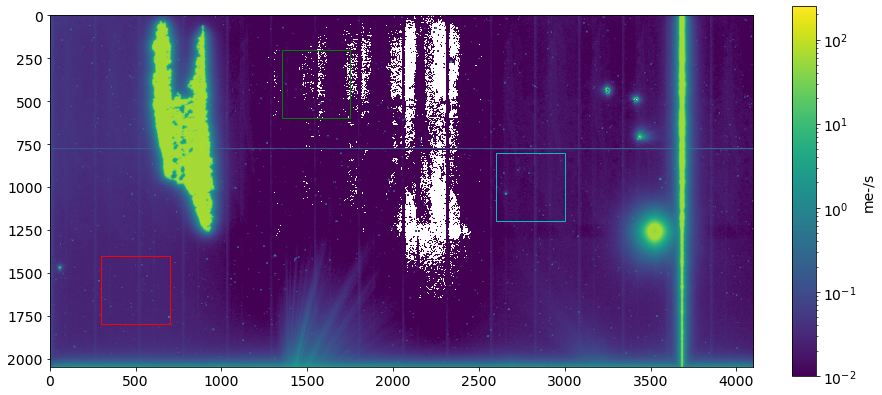

In [98]:
example_image = exposures2hr[6]

print(example_image.get_info())

# Convert ADU to me-/s
exp = example_image.exp_time / 1000 # Convert from ms to s
rate = 1000*example_image.cds_frames[0]/2**14 * 1.2/4 / exp # Assuming high gain mode? Yes #convert to me-

# Define some extraction regions: x1,y1,x2,y2
r1 = (300,1400,700,1800) #red
r2 = (1350,200,1750,600) #green
r3 = (2600,800,3000,1200) #cyan

# Plot image and extraction regions
plt.figure(figsize=[14,8])
plt.imshow(rate, norm=LogNorm(vmin=0.01, vmax=250))
rect1 = plt.Rectangle((r1[0],r1[1]), r1[2]-r1[0], r1[3]-r1[1], facecolor='none', edgecolor='r', linewidth=1)
rect2 = plt.Rectangle((r2[0],r2[1]), r2[2]-r2[0], r2[3]-r2[1], facecolor='none', edgecolor='g', linewidth=1)
rect3 = plt.Rectangle((r3[0],r3[1]), r3[2]-r3[0], r3[3]-r3[1], facecolor='none', edgecolor='c', linewidth=1)
ax = plt.gca()
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
plt.colorbar(fraction=0.05, aspect=15, shrink=0.85, label='me-/s')
plt.show()
plt.close()

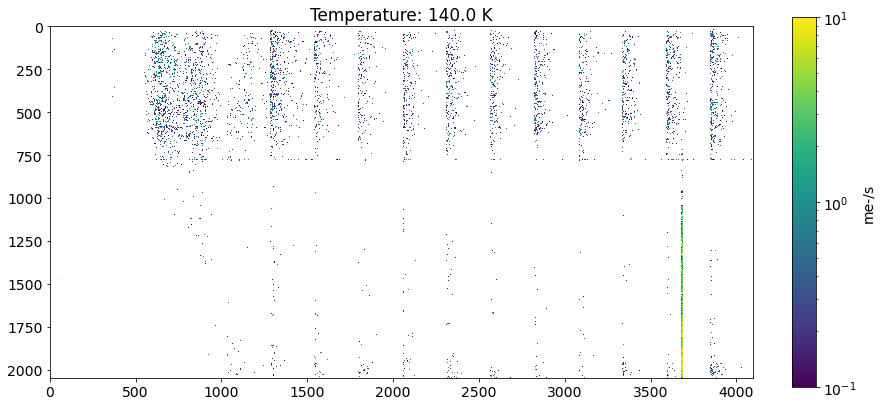

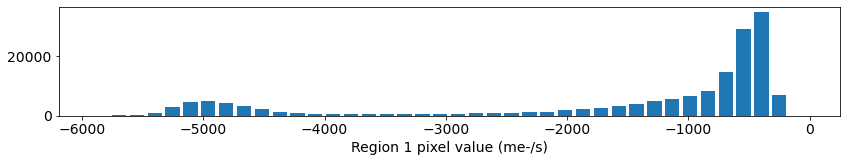

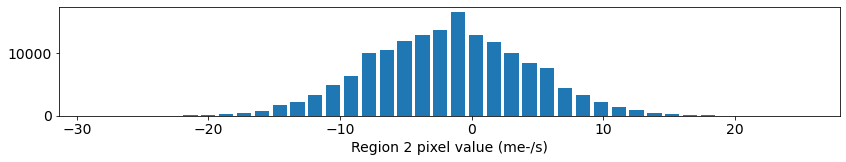

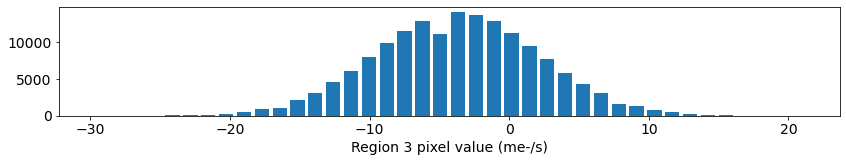

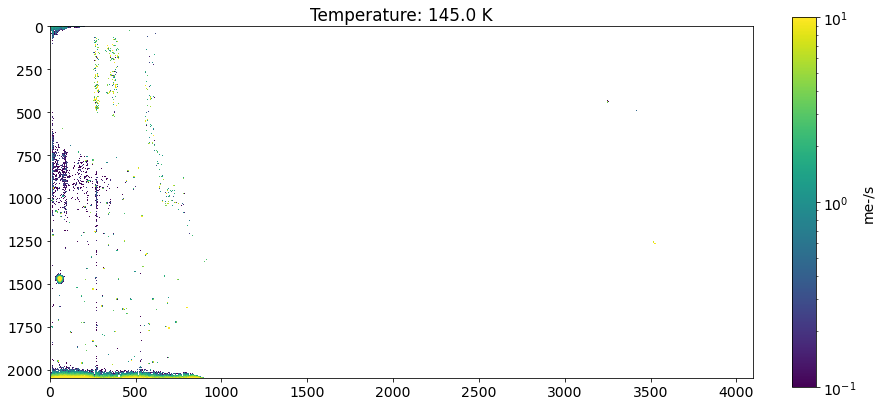

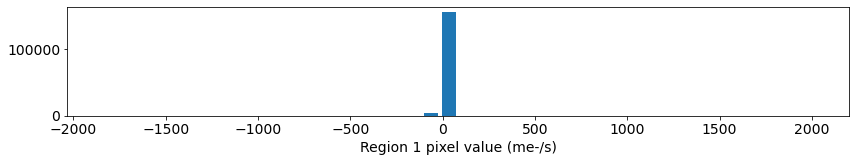

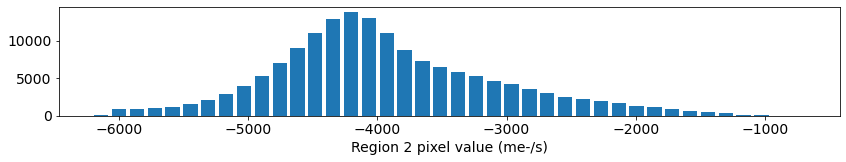

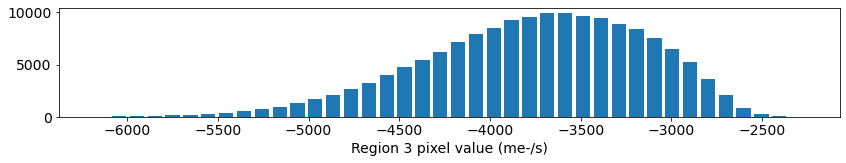

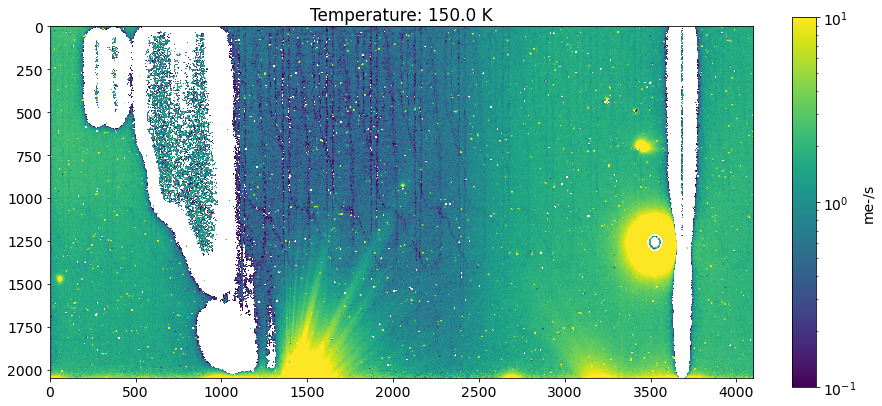

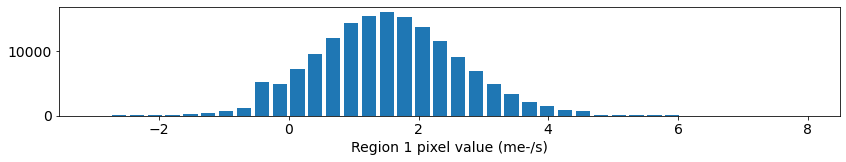

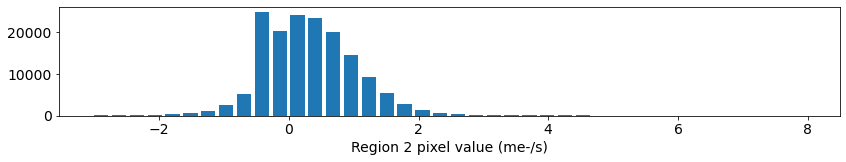

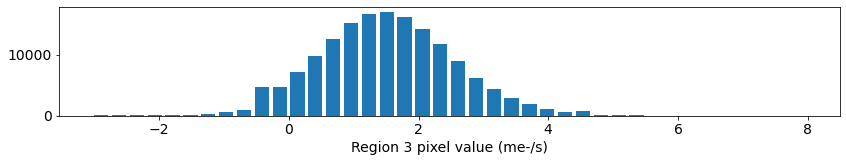

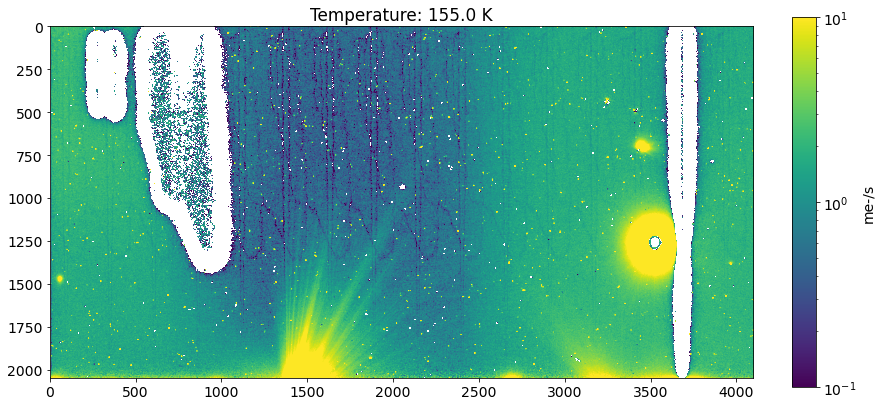

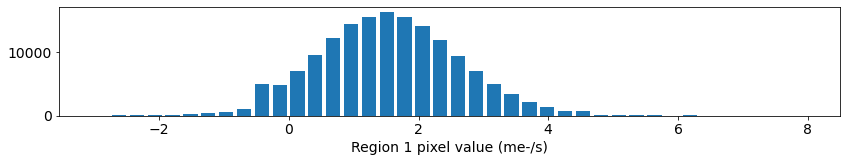

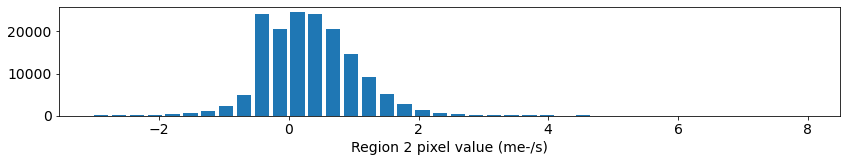

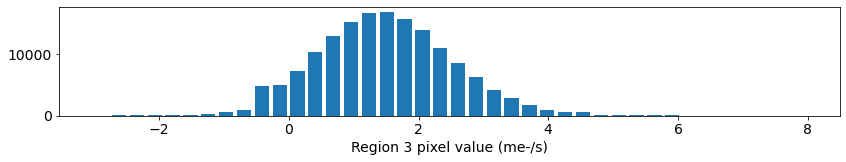

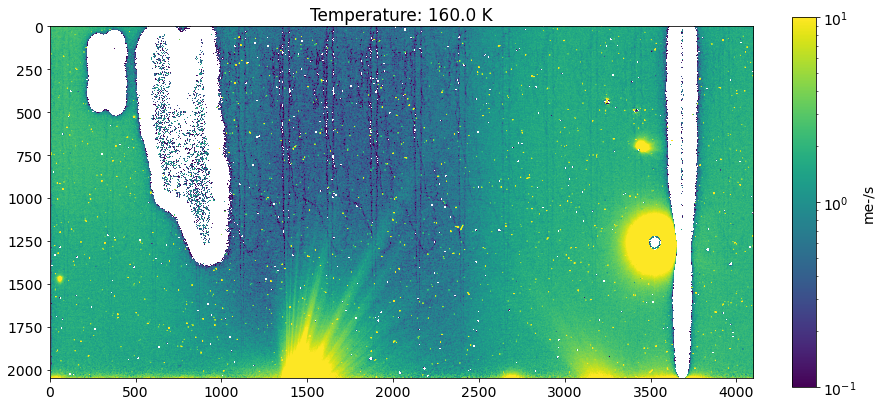

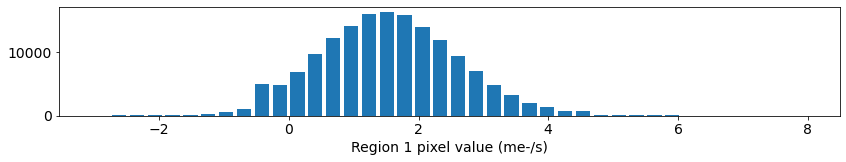

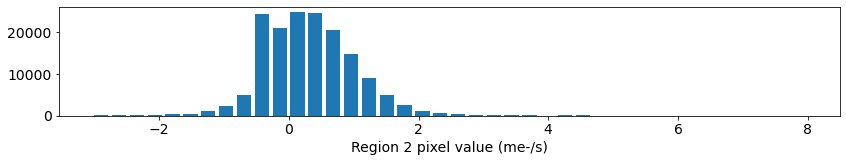

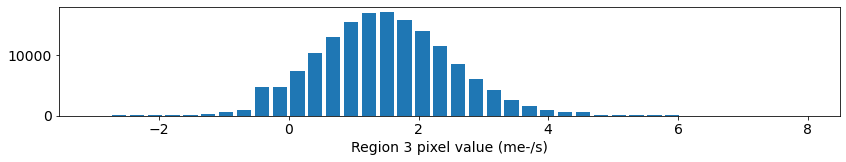

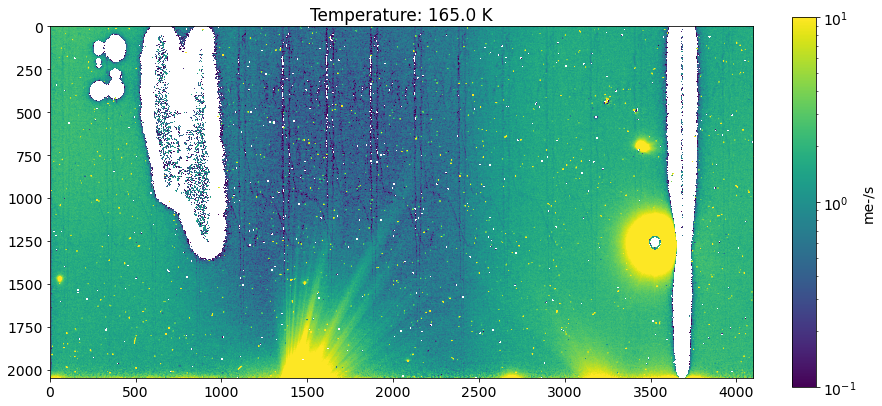

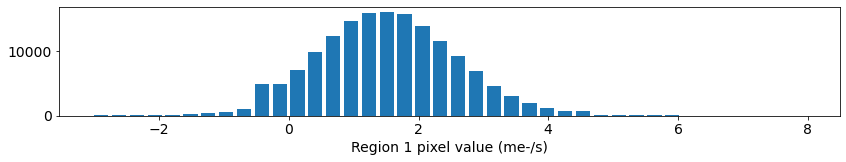

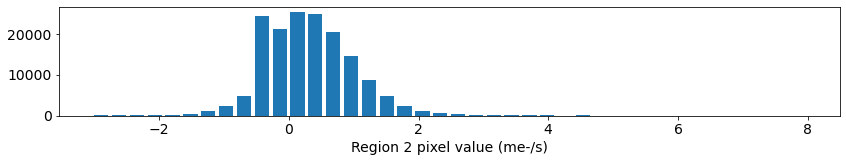

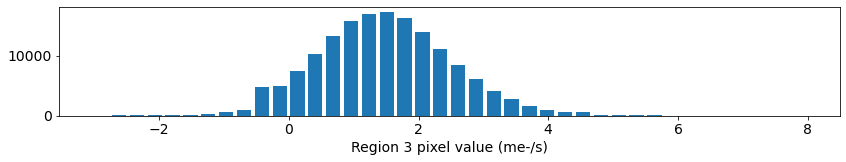

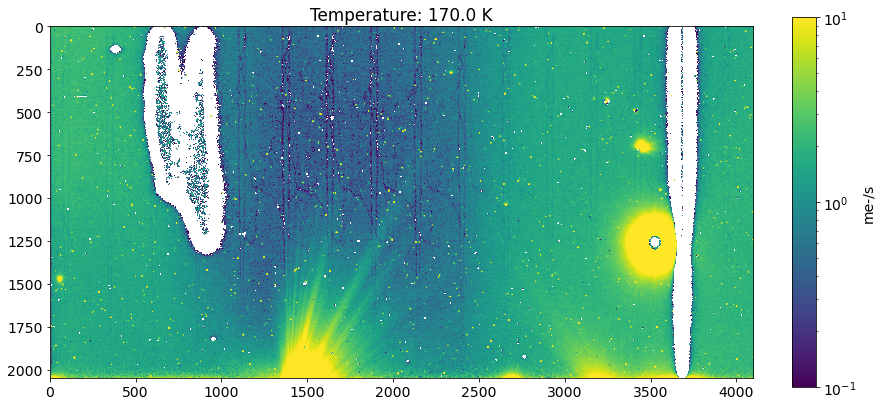

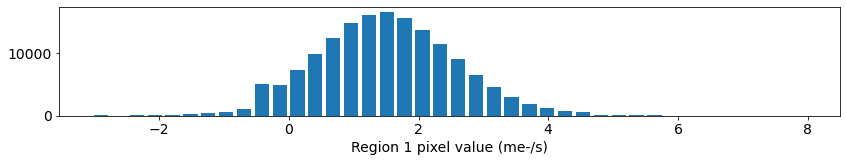

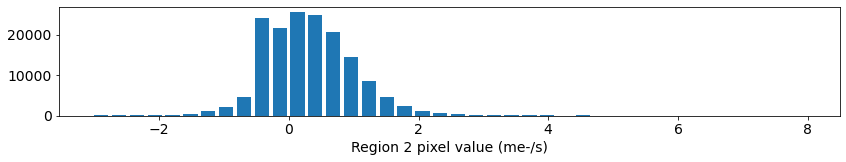

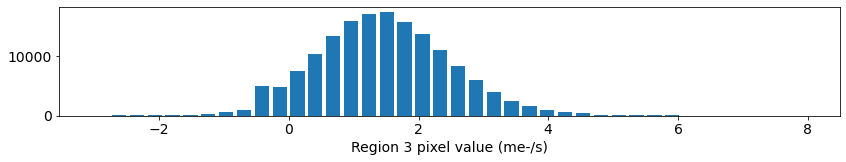

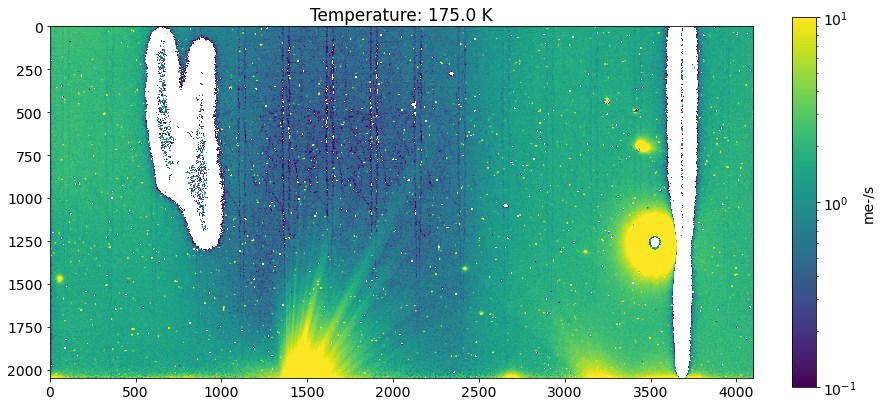

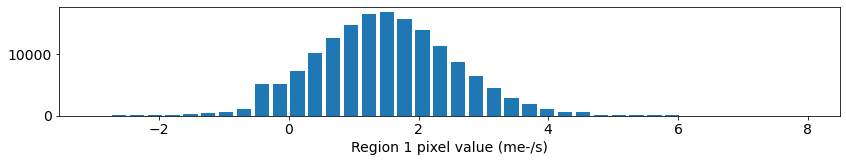

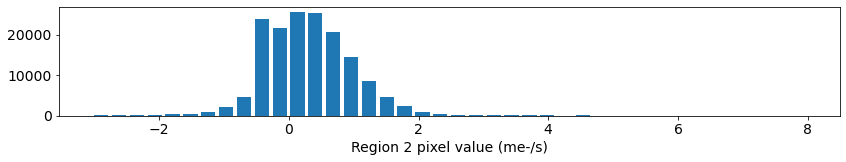

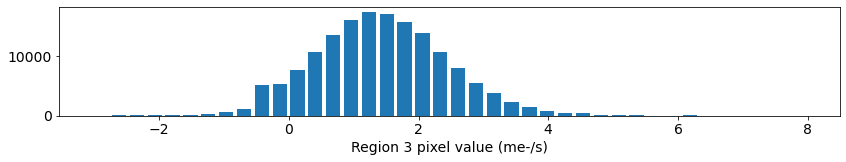

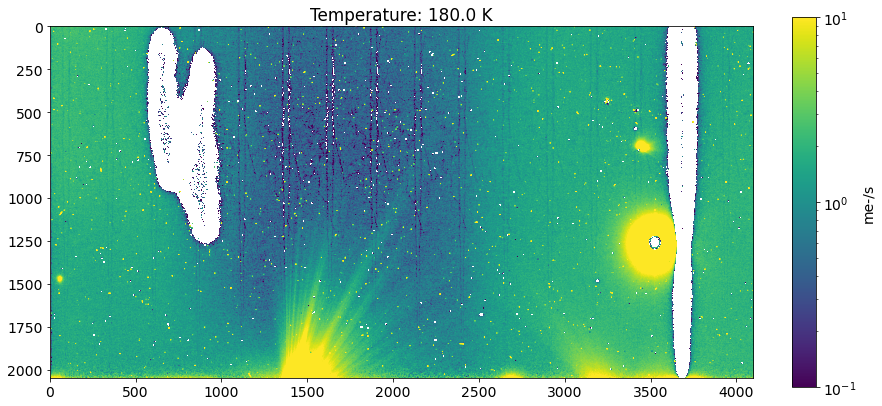

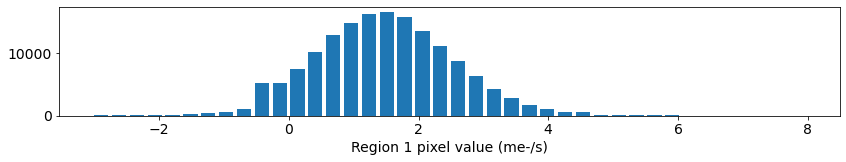

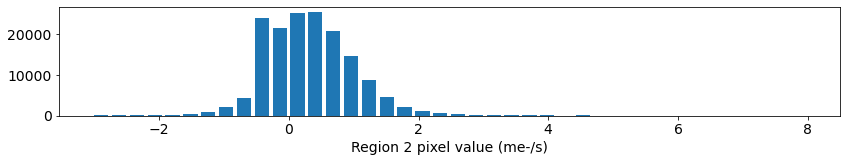

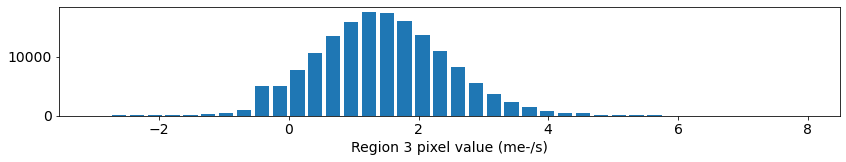

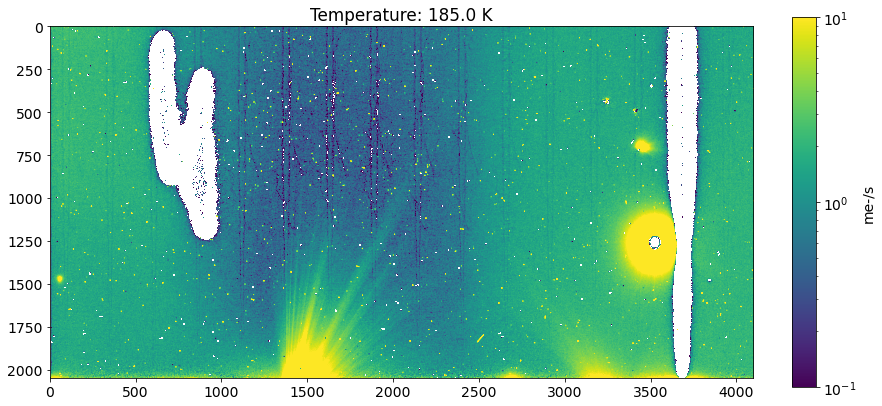

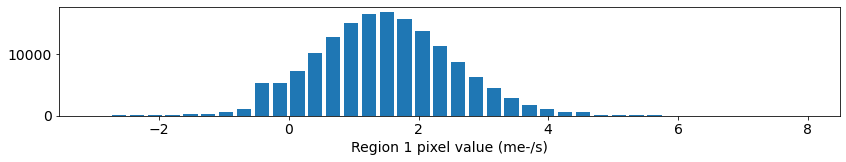

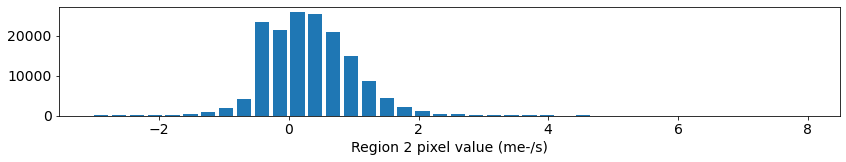

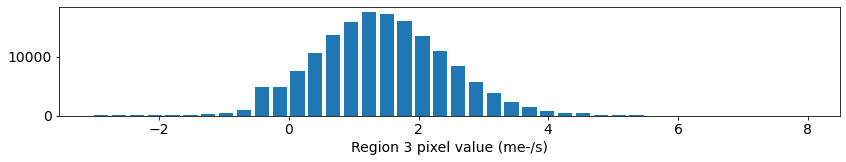

In [116]:
# Taking the difference between the long and short frames to remove common bias
rates1, rates2, rates3 = [], [], []
temps = []

for i in range(len(exposures30min)):
    frame_diff = exposures2hr[i].cds_frames[0] - exposures30min[i].cds_frames[0]
    exp_time_diff = 6400 - 1800
    rate_diff = frame_diff * 1.2 / exp_time_diff * 1000
    
    # Get the median of each extraction region
    region1 = rate_diff[r1[1]:r1[3],r1[0]:r1[2]]
    region2 = rate_diff[r2[1]:r2[3],r2[0]:r2[2]]
    region3 = rate_diff[r3[1]:r3[3],r3[0]:r3[2]]
    
    rates1.append(np.mean(region1))
    rates2.append(np.mean(region2))
    rates3.append(np.mean(region3))
    temps.append(exposures2hr[i].temperature)
    
    plt.figure(figsize=[14,8])
    plt.title('Temperature: {} K'.format(exposures2hr[i].temperature))
    plt.imshow(rate_diff, norm=LogNorm(vmin=0.1, vmax=10))
    rect1 = plt.Rectangle((r1[0],r1[1]), r1[2]-r1[0], r1[3]-r1[1], facecolor='none', edgecolor='r', linewidth=1)
    rect2 = plt.Rectangle((r2[0],r2[1]), r2[2]-r2[0], r2[3]-r2[1], facecolor='none', edgecolor='g', linewidth=1)
    rect3 = plt.Rectangle((r3[0],r3[1]), r3[2]-r3[0], r3[3]-r3[1], facecolor='none', edgecolor='c', linewidth=1)
    plt.colorbar(fraction=0.05, aspect=15, shrink=0.85, label='me-/s')
    plt.show()
    
    # Plot some histograms of the region contents
    if i < 2: # Do anomalous ones separately for now
        hist1, bin_edges1 = np.histogram(region1, bins=40) 
        hist2, bin_edges2 = np.histogram(region2, bins=40)
        hist3, bin_edges3 = np.histogram(region3, bins=40)
    else:
        hist1, bin_edges1 = np.histogram(region1, bins=40, range=(-3,8))
        hist2, bin_edges2 = np.histogram(region2, bins=40, range=(-3,8))
        hist3, bin_edges3 = np.histogram(region3, bins=40, range=(-3,8))
     
    plt.figure(figsize=[14,2])
    plt.bar(bin_edges1[:-1],hist1,width=0.8*(bin_edges1[1]-bin_edges1[0]),align="edge")
    plt.xlabel('Region 1 pixel value (me-/s)')
    plt.show()
     
    plt.figure(figsize=[14,2])
    plt.bar(bin_edges2[:-1],hist2,width=0.8*(bin_edges2[1]-bin_edges2[0]),align="edge")
    plt.xlabel('Region 2 pixel value (me-/s)')
    plt.show()
    
    plt.figure(figsize=[14,2])
    plt.bar(bin_edges3[:-1],hist3,width=0.8*(bin_edges3[1]-bin_edges3[0]),align="edge")
    plt.xlabel('Region 3 pixel value (me-/s)')
    plt.show()

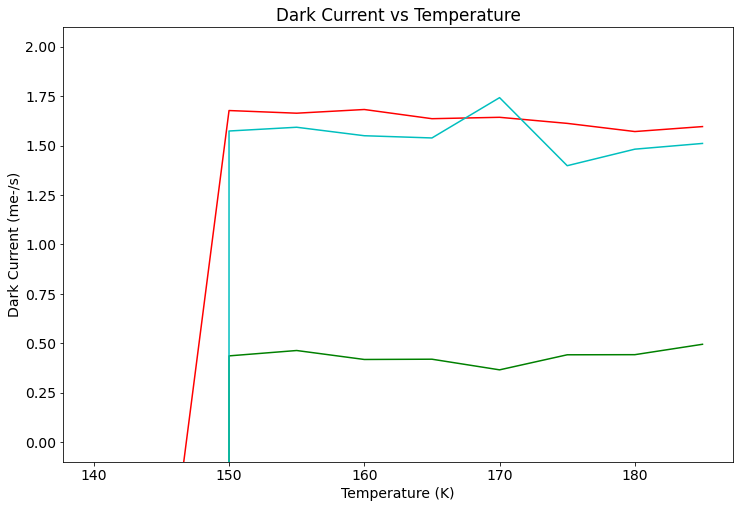

In [118]:
# Plot dark current versus temperature for each region
plt.figure(figsize=[12,8])
plt.title('Dark Current vs Temperature')
plt.plot(temps,rates1,color='r')
plt.plot(temps,rates2,color='g')
plt.plot(temps,rates3,color='c')
plt.xlabel('Temperature (K)')
plt.ylabel('Dark Current (me-/s)')
plt.ylim([-0.1,2.1])
plt.show()